In [1]:
import networkx as nx
import random as rnd

n_nodes=30  #number of nodes
min_servers=2 #minimum number of servers in the network 
max_servers=3 #maximum number of servers in the network 

# Creation of random graph
net = nx.barabasi_albert_graph(n_nodes, 2, seed=42)
net = net.to_directed() #convert to direct graf

#data for the network 
SRV_CMP_PWR = 1000

# Capacity of each link in Mb/s
SRV_LINK_CAP = 10000
ROUT_LINK_CAP = 20000
ENDP_LINK_CAP = 1000

# Probability of assigning node as router or server
SERV_PROB = 0.1
ROUT_PROB = 1 - SERV_PROB

# demand that represents data sent from servers to endpoints in MFLOPS
ENDP_DEMAND = 10
SRV_DEMAND = 0  # Server demand is adjusted later
ROUT_DEMAND = 0 #always 0 

# delay that each node introduce in ms
SRV_DELAY = 10
ROUT_DELAY = 1
ENDP_DELAY = 0.2

# cost of using each link
ENDP_WEIGHT = 10
ROUT_WEIGHT = 100
SRV_WEIGHT = 500

# cost of open each link
ENDP_LCOST = 0
ROUT_LCOST = 0
SRV_LCOST = 0

# cost of using each equipment
ENDP_COST = 0
ROUT_COST = 0
SRV_COST = 0

# colors of devices used in visualization
ENDP_COLOR = 'orange'
ROUT_COLOR = 'green'
SRV_COLOR = 'red'

In [2]:
# Assigning role for each node

while 1: #do until the network have enough servers
    color_map = []
    list_servers =[]
    for v in nx.degree(net):

        # if node connects to 2 neighbours
        if v[1] == 4:
           
            if rnd.random() <= SERV_PROB and len(list_servers) < max_servers :
                # mark as server:
                net.nodes[v[0]]['type'] = 'Server'
                net.nodes[v[0]]['demand'] = SRV_DEMAND
                net.nodes[v[0]]['delay'] = SRV_DELAY
                net.nodes[v[0]]['Cost'] = SRV_COST
                color_map.append(SRV_COLOR)
                list_servers.append(v[0])
                
                # add data of connection
                for connection in list(nx.neighbors(net, v[0])):
                    net[v[0]][connection]['capacity'] = SRV_LINK_CAP            
                    net[v[0]][connection]['weight'] = SRV_WEIGHT
                    net[v[0]][connection]['Cost'] = SRV_WEIGHT
                
            else:
                
                # mark as endpoint:
                net.nodes[v[0]]['type'] = 'Endpoint'
                net.nodes[v[0]]['demand'] = ENDP_DEMAND
                net.nodes[v[0]]['delay'] = ENDP_DELAY
                net.nodes[v[0]]['Cost'] = ENDP_COST
                color_map.append(ENDP_COLOR)

                # add data of connection
                for connection in list(nx.neighbors(net, v[0])):
                    net[v[0]][connection]['capacity'] = ENDP_LINK_CAP            
                    net[v[0]][connection]['weight'] = ENDP_WEIGHT
                    net[v[0]][connection]['Cost'] = ENDP_LCOST

        # if node has more connections choose as Router
        else:
            
            net.nodes[v[0]]['type'] = 'Router' 
            net.nodes[v[0]]['demand'] = ROUT_DEMAND
            net.nodes[v[0]]['delay'] = ROUT_DELAY
            net.nodes[v[0]]['Cost'] = ROUT_COST
            color_map.append(ROUT_COLOR)                                                 

        adj = list(nx.neighbors(net, v[0]))
        for neighbour in adj:
            if net.nodes[v[0]]['type'] == 'Router':
                net[v[0]][neighbour]['capacity'] = ROUT_LINK_CAP               
                net[v[0]][neighbour]['weight'] = ROUT_WEIGHT
                net[v[0]][neighbour]['Cost'] = ROUT_LCOST
            
                    
    if len(list_servers) >= min_servers: #minimum servers at the network
        break


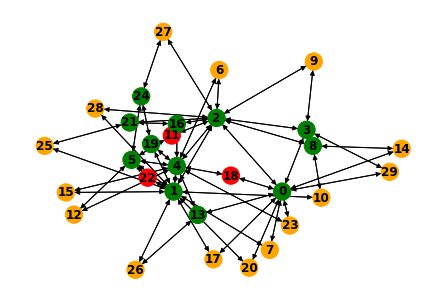

In [4]:
#draw the network with each role
import matplotlib.pyplot as plt
nx.draw(net, pos=nx.spring_layout(net), with_labels=True, font_weight='bold', node_color=color_map)
plt.savefig("path_directed.png")
plt.show()


In [5]:
## Add demands to servers
## since we need equal amount of demand send and receive for alghoritm to work and 
## we have random number of endpoint and servers, following code will adjust demand 
## for servers to make them equal with demand for endpoints
Demand_EPs=0
Cont_serv=0
for i in net.nodes:
    if net.nodes[i]['type'] == 'Endpoint':
        Demand_EPs=net.nodes[i]['demand']+Demand_EPs

Demand_SVs=int(Demand_EPs/len(list_servers))

for i in range (len(list_servers)):
    if i == len(list_servers)-1:
        Demand_SVs=Demand_EPs-(Demand_SVs*(len(list_servers)-1))
    net.nodes[list_servers[i]]['demand']=-Demand_SVs
    
for i in net.nodes:
    if net.nodes[i]['demand'] > 0:
        print ('Demand of node:',i,net.nodes[i]['type'],'=',net.nodes[i]['demand'])

Demand of node: 6 Endpoint = 10
Demand of node: 7 Endpoint = 10
Demand of node: 9 Endpoint = 10
Demand of node: 10 Endpoint = 10
Demand of node: 12 Endpoint = 10
Demand of node: 14 Endpoint = 10
Demand of node: 15 Endpoint = 10
Demand of node: 17 Endpoint = 10
Demand of node: 20 Endpoint = 10
Demand of node: 23 Endpoint = 10
Demand of node: 25 Endpoint = 10
Demand of node: 26 Endpoint = 10
Demand of node: 27 Endpoint = 10
Demand of node: 28 Endpoint = 10
Demand of node: 29 Endpoint = 10


In [6]:
## solving network for minimum cost.
[flowCost, flowDict] = nx.algorithms.network_simplex(net)

print("Total cost:", flowCost)
print("Used links ((node1, node2), flow):", 
      sorted([((u, v), flowDict[u][v]) for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]))

Total cost: 90000
Used links ((node1, node2), flow): [((0, 14), 10), ((0, 20), 10), ((0, 29), 10), ((1, 7), 10), ((1, 10), 10), ((1, 17), 10), ((1, 25), 10), ((1, 26), 10), ((2, 6), 10), ((2, 9), 10), ((2, 27), 10), ((2, 28), 10), ((4, 15), 10), ((4, 23), 10), ((5, 12), 10), ((11, 2), 40), ((11, 5), 10), ((18, 0), 30), ((18, 4), 20), ((22, 1), 50)]


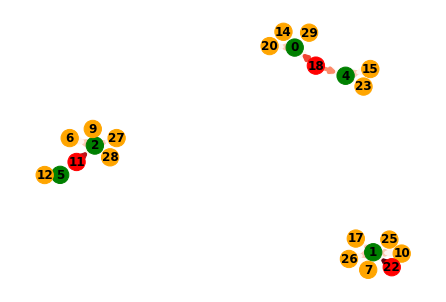

In [7]:
#Draw Graf of solution for minimum cost
spentEdges = [(u, v) for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]
color_map2=[]
color_edge_map=[]
Net_demand = nx.Graph()

Net_demand.add_edges_from(spentEdges)
Net_demand = Net_demand.to_directed()

for i in Net_demand.nodes:
    if net.nodes[i]['type'] == 'Endpoint':
        color_map2.append(ENDP_COLOR)
    if net.nodes[i]['type'] == 'Router':
        color_map2.append(ROUT_COLOR)
    if net.nodes[i]['type'] == 'Server':
        color_map2.append(SRV_COLOR) 

for edg in Net_demand.edges():
    if edg in spentEdges or (edg[1],edg[0]) in spentEdges:
        color_edge_map.append(flowDict[edg[0]][edg[1]])
        #print (flowDict[edg[0]][edg[1]])
        #         print(edg)
    else:
        color_edge_map.append(5)
        
nx.draw(Net_demand, pos=nx.spring_layout(Net_demand), with_labels=True,edge_color=color_edge_map,width=4, font_weight='bold',node_color=color_map2,edge_cmap=plt.cm.Reds)
plt.savefig("path_directed.png")
plt.show()

In [8]:
#create dataframe and .cvs file with the information of the network
import pandas as pd

data = pd.DataFrame([], columns=['Edge_id','From_id','To_id','From_type','To_type','Capacity','U_cost', 'O_cost'])
for v in nx.degree(net): 
    adj = list(nx.neighbors(net, v[0]))
    for neig in adj:
        data = data.append(pd.DataFrame([['',v[0]+1,neig+1,net.nodes[v[0]]['type'],
                net.nodes[neig]['type'],net[v[0]][neig]['capacity'],net[v[0]][neig]['weight'],
                net[v[0]][neig]['Cost']]], columns=['Edge_id','From_id','To_id','From_type','To_type','Capacity','U_cost','O_cost']), 
                ignore_index = True)

data.index=data.index+1            
data['Edge_id'] = data.index #add index route
data.to_csv('network.csv') #create a .csv file 
#print (data)
data.head()

,Edge_id,From_id,To_id,From_type,To_type,Capacity,U_cost,O_cost
1,1,1,3,Router,Router,20000,100,0
2,2,1,4,Router,Router,20000,100,0
3,3,1,8,Router,Endpoint,20000,100,0
4,4,1,14,Router,Router,20000,100,0
5,5,1,15,Router,Endpoint,20000,100,0


In [9]:
#create dataframe with the information of the nodes in the network 
dat_node = pd.DataFrame([], columns=['id','type'])
dat_node['id'] = data['From_id']
dat_node['type'] = data['From_type']
dat_node = dat_node.drop_duplicates(subset='id', keep='first')
dat_node = dat_node.reset_index(drop=True)
dat_node['Cost'] = ''

dat_node.index= dat_node.index+1
#add the cost of using the equipment
for i in range (1, len(dat_node)+1):
    if dat_node['type'][i][0:1] == 'R':
        dat_node['Cost'][i] = ROUT_COST
    elif dat_node['type'][i][0:1] == 'S':
        dat_node['Cost'][i] = SRV_COST
    elif dat_node['type'][i][0:1] == 'E':
        dat_node['Cost'][i] = ENDP_COST
#print (dat_node)
dat_node.head()

,id,type,Cost
1,1,Router,0
2,2,Router,0
3,3,Router,0
4,4,Router,0
5,5,Router,0


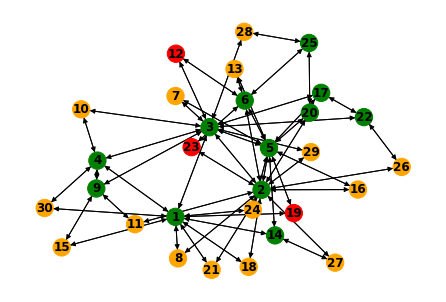

In [10]:
#create the network with the new indexes for the GMLP program  
Network = nx.Graph()
color_map3 = []
for i in range(1, len(data)+1):
    Network.add_edge(data['From_id'][i], data['To_id'][i])            

Network = Network.to_directed() #convert to direct graf            
            
for v in Network.nodes:
    if dat_node['type'][v][0:1] == 'R':
        color_map3.append(ROUT_COLOR)
    elif dat_node['type'][v][0:1] == 'S':
        color_map3.append(SRV_COLOR)
    elif dat_node['type'][v][0:1] == 'E':
        color_map3.append(ENDP_COLOR) 
            
#draw the network
nx.draw(Network, with_labels=True, font_weight='bold', pos=nx.spring_layout(Network),node_color=color_map3)
plt.savefig("path.png")
plt.show()
#print (data)

In [11]:
#generar demandas 
import random as rnd

list_ep=[]
#obtener los endpoints y servidores de la red 
for i in range (1, len(dat_node)+1):
    if dat_node['type'][i][0:1] == 'E':
        list_ep.append(dat_node['id'][i])

Endp_A=rnd.sample(list_ep,  3)
#print('list Endpoints',list_ep)
#print ('list Endpoints active',Endp_A)

#obtener los vecinos y el nivel en el que se encuentran (saltos)
def level_node (nram):   
    
    list_node = []
    list_type=[]
    list_level=[]
    list_temp=[]
    level=0

    list_node.append(nram)
    list_type.append(dat_node['type'][nram])
    list_level.append(level)
    fle=1      #bandera que indica que se subio de nivel
    list_temp=list_node

    while 1:
        #time.sleep(2)
        list_temp2=[]   
        if fle ==1: #aumentar el nivel de nodo
            level +=1
            fle=0
        else:
            break
        for i in range (len(list_temp)):
            adj = list(nx.neighbors(Network, list_temp[i])) #obtiene los vecinos del nodo        
            for j in range (len(adj)):
                fn=0
                for k in range (len(list_node)):
                    if adj[j]==list_node[k]:
                        fn=1
                if fn == 0:
                    list_temp2.append(adj[j])
                    list_node.append(adj[j])
                    list_type.append(dat_node['type'][adj[j]])
                    list_level.append(level)
                    fle=1
        list_temp=list_temp2

    data_level = pd.DataFrame([], columns=['id','type','level'])    
    data_level['id'], data_level['type'], data_level['level'] =list_node,list_type,list_level
    #print (data_level)
    return data_level

data_demand = pd.DataFrame([], columns=['From','To','Demand'])

for k in range (len(list_ep)):
    ctr_ser=1
    ctr_enp=1
    data_level= level_node(list_ep[k])
    for i in range (1, len(data_level['type'])):
        if data_level['type'][i][0:1]=='S' and ctr_ser<=1:#cantidad de servidores para cada demanda
            ctr_ser+=1
            data_demand = data_demand.append(pd.DataFrame([[data_level['id'][i],list_ep[k],ENDP_DEMAND]], columns=['From','To','Demand']), ignore_index = True)
            #print (data_level['type'][i],data_level['level'][i])
            break
            
data_demand.index=data_demand.index+1
print (data_demand)

   From  To Demand
1    12   7     10
2    19   8     10
3    12  10     10
4    23  11     10
5    19  13     10
6    19  15     10
7    23  16     10
8    19  18     10
9    19  21     10
10   19  24     10
11   23  26     10
12   23  27     10
13   12  28     10
14   23  29     10
15   19  30     10


In [12]:
Vn=n_nodes
En=0
for i in range(1, len(data)+1): 
    if En <= data['Edge_id'][i]:
        En = data['Edge_id'][i]

#create de file data.dat with the information of the network for optimization
with open("data.dat", "w") as f:
    f.write("""
data;
#-----------------------------------------------------------------------
#liczba łuki, zapotrzebowań oraz ścieżek

param Vn := {Vn};
param En := {En};
param Dn := {Dn};
param Pn := {Pn};

        """.format(Vn=Vn,Pn=len(list_servers), En=En, Dn=len(data_demand)))

#*************************************************************************

with open("data.dat", "a") as f:
    f.write("""
#-----------------------------------------------------------------------
#set of servers in  the network 
set VS :=
""")

    for i in range(len(list_servers)):       
        f.write("""      {s}
""".format(s=list_servers[i]+1))
    f.write(""";""")

#*************************************************************************

with open("data.dat", "a") as f:
    f.write("""
#-----------------------------------------------------------------------
#rozmiar zapotrzebowania d, węzeł żródłowy d, węzeł docelowy d
param : h  t :=
""")

    for i in range(1,len(data_demand)+1):       
        f.write("""  {d}      {h}  {t}
""".format(d=data_demand.index[i-1], h=data_demand['Demand'][i],t=data_demand['To'][i]))
    f.write(""";""")

#*************************************************************************     

with open("data.dat", "a") as f:
    f.write("""
#-----------------------------------------------------------------------
#węzłe-łącze  Aev(e,v) 
param : A :=
""")

    for i in range(1, En+1):       
        f.write("""  {link_number}  {From_edge_number}    1
""".format(link_number=data['Edge_id'][i], From_edge_number=data['From_id'][i]))
    f.write(""";""")

#*************************************************************************    
    
with open("data.dat", "a") as f:
    f.write("""

#----------------------------------------------------------------------- 
#węzłe-łącze  Bev(e,v) 
param : B :=
""")
        
    for i in range(1,En+1):       
        f.write("""  {link_number}  {to_edge_number}    1
""".format(link_number=data['Edge_id'][i], to_edge_number=data['To_id'][i]))
    f.write(""";""")

#*************************************************************************    
    
with open("data.dat", "a") as f:
    f.write("""

#-----------------------------------------------------------------------       
#koszt jednostkowy użycia przepływności na łączach     
param : K :=
""")
    for i in range(1,En+1):       
        f.write("""  {link_number}  {cost}
""".format(link_number=data['Edge_id'][i], cost=data['U_cost'][i]))
    f.write(""";""")
    
#*************************************************************************    
    
with open("data.dat", "a") as f:
    f.write("""

#-----------------------------------------------------------------------       
#koszt jednostkowy użycia przepływności na łączach     
param : c :=
""")
    for i in range(1,En+1):       
        f.write("""  {link_number}  {cap}
""".format(link_number=data['Edge_id'][i], cap=data['Capacity'][i]))
    f.write(""";""")
        
#*************************************************************************        
        
with open("data.dat", "a") as f:
    f.write("""
    
#----------------------------------------------------------------------- 
#upper bound for the degree of transit node v     
param : G :=
""")
    for i in range(1,Vn+1):       
        f.write("""  {node_number}  {grade}
""".format(node_number=i, grade=Network.degree[i]))        
    f.write(""";""")

#*************************************************************************      
    
    
with open("data.dat", "a") as f:
     f.write("""
end;
""")

In [13]:
#run the math-program with the data of the network created 
!cbc projekt.mod%data.dat -solve -solu result.csv

Welcome to the CBC MILP Solver 
Version: Trunk (unstable) 
Build Date: Mar 27 2019 

command line - cbc projekt.mod%data.dat -solve -solu result.csv (default strategy 1)
GMPL model file ./projekt.mod and data file ./data.dat
Reading model section from ./projekt.mod...
91 lines were read
Reading data section from ./data.dat...
540 lines were read
Generating z...
Generating c1f...
Generating c2f...
Generating c3f...
Generating c1b...
Generating c2b...
Generating c3b...
Generating c4b...
Generating c5b...
Generating c6b...
Generating cd...
Generating c4f...
Generating c6f...
Generating c4...
Generating cc...
Model has been successfully generated
Problem projekt has 16155 rows, 16972 columns and 57621 elements
Model was imported from ./projekt.mod in 3.219761 seconds
Continuous objective value is 90000 - 0.24 seconds
Cgl0002I 60 variables fixed
Cgl0004I processed model has 14347 rows, 15277 columns (10080 integer (10080 of which binary)) and 50602 elements
Cbc0038I Initial state - 0 intege

In [14]:
#clean and organize the data obtained with the GMLP program 
#obtain the data of dual homing "available links"
with open("result.csv", "r") as f:
    fl =f.readlines()
    f.close()

data_r = pd.DataFrame([], columns=['Demand','Edge','State'])        
for j in range (len(fl)):
    flag =0
    temp1=''
    temp2=''
    temp3=''
    for i in range (len(fl[j])):
        if fl[j][i] == 'u' and flag == 0:
            flag =1                    
        elif fl[j][i] != '[' and flag == 1:
            break
        elif fl[j][i] == '[' and flag == 1:
            flag =2
        elif fl[j][i] != ',' and flag == 2:        
            temp1 = temp1+fl[j][i]
        elif fl[j][i] == ',' and flag == 2:
            flag =3            
        elif fl[j][i] != ',' and flag == 3:
            temp2 = temp2+fl[j][i]
        elif fl[j][i] == ',' and flag == 3:
            flag =4 
        elif fl[j][i] == ']' and flag == 4:
            flag =5
        elif fl[j][i] != ' ' and flag == 5:
            flag =6
            temp3 = temp3+fl[j][i]
        elif fl[j][i] != ' ' and flag == 6:
            temp3 = temp3+fl[j][i]
        elif fl[j][i] == ' ' and flag == 6:
            break
    if temp1 != '':        
        data_r = data_r.append(pd.DataFrame([[temp2,temp1,temp3]], columns=['Demand','Edge','State']), ignore_index = True)        
print (data_r)

    Demand Edge State
0        1   11     1
1        1   28     1
2        1   28     1
3        1   31     1
4        1   44     1
5        1   70     1
6        1   70     1
7        1   87     1
8        1   96     1
9        2    3     1
10       2    3     1
11       2   14     1
12       2   24     1
13       2   70     1
14       2   86     1
15       2   96     1
16       3    2     1
17       3   11     1
18       3   30     1
19       3   30     1
20       3   31     1
21       3   39     1
22       3   70     1
23       3   70     1
24       3   86     1
25       3   96     1
26       4    1     1
27       4   15     1
28       4   15     1
29       4   20     1
..     ...  ...   ...
103     12   96     1
104     12   96     1
105     13    1     1
106     13   31     1
107     13   34     1
108     13   34     1
109     13   57     1
110     13   70     1
111     13   70     1
112     13   86     1
113     13   97     1
114     13  102     1
115     14    1     1
116     14

In [15]:
#draw GRAF with the available links
Net_demand = nx.Graph()
data_r['From']=''
data_r['To']=''
for i in range(len(data_r)):
    Net_demand.add_node(data['From_id'][int(data_r['Edge'][i])])
    Net_demand.add_node(data['To_id'][int(data_r['Edge'][i])])
    data_r['From'][i]=data['From_id'][int(data_r['Edge'][i])]
    data_r['To'][i]=data['To_id'][int(data_r['Edge'][i])]

for i in range(len(data_r)):    
    Net_demand.add_edge(data_r['From'][i],data_r['To'][i])
#data_r.head()

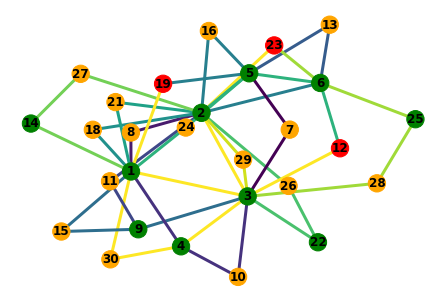

In [16]:
#create the network with the new indexes for the GMLP program  
Net_links = nx.Graph()
color_map4 = []
color_edge_map2=[]
for i in range(len(data_r)):    
    Net_links.add_edge(data['From_id'][int(data_r['Edge'][i])], 
                     data['To_id'][int(data_r['Edge'][i])], color= int(data_r['Demand'][i])*2 )            
        
#Net_links = Net_links.to_directed() #convert to direct graf            
#Net_links = Net_links.to_directed()            
for v in Net_links.nodes:
    if dat_node['type'][v][0:1] == 'R':
        color_map4.append(ROUT_COLOR)
    elif dat_node['type'][v][0:1] == 'S':
        color_map4.append(SRV_COLOR)
    elif dat_node['type'][v][0:1] == 'E':
        color_map4.append(ENDP_COLOR)    

for v in Net_links.edges:
    color_edge_map2.append((Net_links.edges[v]['color']))        


nx.draw(Net_links, pos=nx.spring_layout(Net_links), with_labels=True, font_weight='bold', edge_color=color_edge_map2,width=3, node_color=color_map4)
plt.savefig("Available_links.png")
plt.show()
#print (data)

In [17]:
#clean and organize the data obtained with the GMLP program 
#obtain the data of available links using for used to fulfill the demand
with open("result.csv", "r") as f:
    fl =f.readlines()
    f.close()

data_r = pd.DataFrame([], columns=['Demand','Edge','flow'])        
for j in range (len(fl)):
    flag =0
    temp1=''
    temp2=''
    temp3=''
    for i in range (len(fl[j])):
        if fl[j][i] == 'x' and flag == 0:
            flag =1                    
        elif fl[j][i] != '[' and flag == 1:
            break
        elif fl[j][i] == '[' and flag == 1:
            flag =2
        elif fl[j][i] != ',' and flag == 2:        
            temp1 = temp1+fl[j][i]
        elif fl[j][i] == ',' and flag == 2:
            flag =3            
        elif fl[j][i] != ',' and flag == 3:
            temp2 = temp2+fl[j][i]
        elif fl[j][i] == ',' and flag == 3:
            flag =4 
        elif fl[j][i] == ']' and flag == 4:
            flag =5
        elif fl[j][i] != ' ' and flag == 5:
            flag =6
            temp3 = temp3+fl[j][i]
        elif fl[j][i] != ' ' and flag == 6:
            temp3 = temp3+fl[j][i]
        elif fl[j][i] == ' ' and flag == 6:
            break
    if temp1 != '':        
        data_r = data_r.append(pd.DataFrame([[temp2,temp1,temp3]], columns=['Demand','Edge','flow']), ignore_index = True)        


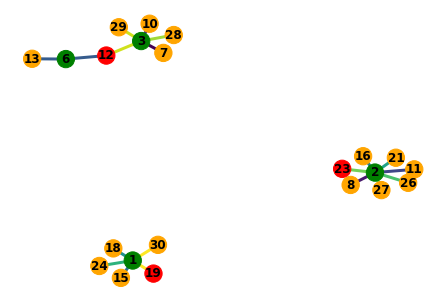

   Demand Edge flow
0       1   28   10
1       1   70   10
2       2   14   10
3       2   96   10
4       3   30   10
5       3   70   10
6       4   15   10
7       4   96   10
8       5   55   10
9       5   71   10
10      6    5   10
11      6   86   10
12      7   16   10
13      7   96   10
14      8    6   10
15      8   86   10
16      9   19   10
17      9   96   10
18     10    9   10
19     10   86   10
20     11   21   10
21     11   96   10
22     12   22   10
23     12   96   10
24     13   34   10
25     13   70   10
26     14   35   10
27     14   70   10
28     15   10   10
29     15   86   10


In [18]:
#draw GRAF with demand flow

Net_demand2 = nx.Graph()
color_map5 = []
color_edge_map3=[]
for i in range(len(data_r)):    
    Net_demand2.add_edge(data['From_id'][int(data_r['Edge'][i])], 
                     data['To_id'][int(data_r['Edge'][i])], color= int(data_r['Demand'][i])*2 )            
        
for v in Net_demand2.nodes:
    if dat_node['type'][v][0:1] == 'R':
        color_map5.append(ROUT_COLOR)
    elif dat_node['type'][v][0:1] == 'S':
        color_map5.append(SRV_COLOR)
    elif dat_node['type'][v][0:1] == 'E':
        color_map5.append(ENDP_COLOR)    

for v in Net_demand2.edges:
    color_edge_map3.append((Net_demand2.edges[v]['color']))        


nx.draw(Net_demand2, pos=nx.spring_layout(Net_demand2), with_labels=True, font_weight='bold', edge_color=color_edge_map3,width=3, node_color=color_map5)
plt.savefig("Demand_Gmpl.png")
plt.show()
print (data_r)